In [1]:
import constants as co
from analyzers import analyze_classifier, analyze_regressor, get_model_predictions
from auxiliary import loggers

from pathlib import Path
import sys

import pandas as pd
import numpy as np
import os

import pickle
import json
import re

%matplotlib inline
import seaborn as sns

pd.set_option('display.max_columns', None)
random_seed = 42

%config Completer.use_jedi = False

l = loggers.get_logger(logger_name="logger")

METHOD_PREFIX = "rf"
RESULT_FILE_REGRESSOR = "result_regressor_rf.csv"
RESULT_FILE_CLASSIFIER = "result_classifier_rf.csv"

In [2]:
l.info(os.environ['CONDA_DEFAULT_ENV'])

2023-01-22 16:06:01,600 - logger - INFO - rorgammaqsar


In [3]:
def parse_results_classifier(file_name, n_rows, n_dec=4):
    results = pd.read_csv(file_name, header=None)
    results.columns = ["use case", "precision", "recall", "accuracy", "f1", "rocauc", "ap", "mcc"]
    results_test = results.loc[list(range(0, n_rows, 2)), :]
    results_train = results.loc[list(range(1, n_rows, 2)), :]
    results_test.iloc[:, 1:] = results_test.iloc[:, 1:].apply(lambda x: np.round(x, n_dec))
    results_train.iloc[:, 1:] = results_train.iloc[:, 1:].apply(lambda x: np.round(x, n_dec))
    return results_test, results_train

def parse_results_regressor(file_name, n_rows, n_dec=4):
    results = pd.read_csv(file_name, header=None)
    results.columns = ["use case", "r2", "mse", "msle", "mae", "mape"]
    results_test = results.loc[list(range(0, n_rows, 2)), :]
    results_train = results.loc[list(range(1, n_rows, 2)), :]
    results_test.iloc[:, 1:] = results_test.iloc[:, 1:].apply(lambda x: np.round(x, n_dec))
    results_train.iloc[:, 1:] = results_train.iloc[:, 1:].apply(lambda x: np.round(x, n_dec))
    return results_test, results_train

def prepare_methodology_naming(series, methodology_in="M_RandomForest", methodology_out="RF"):
    return series.apply(lambda x: re.sub(methodology_in, methodology_out, x)).apply(lambda x: re.sub("_NoScaling", "", x)).apply(lambda x: re.sub("median_100", "median100", x)).apply(lambda x: re.sub("mean_100_", "mean100_", x))\
    .apply(lambda x: re.sub("mean_1000000", "meanNoLim", x)).apply(lambda x: re.sub("FP_MD", "FPMD", x)).apply(lambda x: re.sub("PCA_128", "PCA128", x)).apply(lambda x: re.sub("PCA_256", "PCA256", x))\
    .apply(lambda x: re.sub("PCA_512", "PCA512", x)).apply(lambda x: re.sub("PCA_1024", "PCA1024", x)).apply(lambda x: re.sub("_", ",", x))

In [4]:
best_classifiers = pd.DataFrame()
best_regressors = pd.DataFrame()

# Random forest

In [5]:
results_test, results_train = parse_results_classifier(file_name="result_classifier_rf.csv", n_rows=36)
results_test["use case"] = prepare_methodology_naming(results_test["use case"], methodology_in = "M_RandomForest", methodology_out = "RF")
results_train["use case"] = prepare_methodology_naming(results_train["use case"], methodology_in = "M_RandomForest", methodology_out = "RF")
best_classifiers = pd.concat([best_classifiers, results_test.sort_values("accuracy", ascending=False).iloc[[0],:]])
best_classifiers

,use case,precision,recall,accuracy,f1,rocauc,ap,mcc
6,"RF,FP,NoPCA,median100,test",0.8931,0.966,0.9013,0.9281,0.8712,0.8851,0.7778


In [6]:
results_test.mean()

/tmp/ipykernel_31177/34622521.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_test.mean()


precision    0.873356
recall       0.939139
accuracy     0.864456
f1           0.904383
rocauc       0.817578
ap           0.861683
mcc          0.674456
dtype: float64

In [7]:
print(results_test.style.format({"precision": '{:.4f}', "recall": '{:.4f}', "accuracy": '{:.4f}', "f1": '{:.4f}', "rocauc": '{:.4f}', "ap": '{:.4f}', "mcc": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrrrr}
use case & precision & recall & accuracy & f1 & rocauc & ap & mcc \\
RF,MD,NoPCA,median100,test & 0.8688 & 0.9456 & 0.8700 & 0.9055 & 0.8346 & 0.8573 & 0.7046 \\
RF,MD,NoPCA,mean100,test & 0.8688 & 0.9456 & 0.8700 & 0.9055 & 0.8346 & 0.8573 & 0.7046 \\
RF,MD,NoPCA,meanNoLim,test & 0.8667 & 0.9235 & 0.8387 & 0.8942 & 0.7617 & 0.8568 & 0.5616 \\
RF,FP,NoPCA,median100,test & 0.8931 & 0.9660 & 0.9013 & 0.9281 & 0.8712 & 0.8851 & 0.7778 \\
RF,FP,NoPCA,mean100,test & 0.8931 & 0.9660 & 0.9013 & 0.9281 & 0.8712 & 0.8851 & 0.7778 \\
RF,FP,NoPCA,meanNoLim,test & 0.8889 & 0.9180 & 0.8548 & 0.9032 & 0.7975 & 0.8765 & 0.6145 \\
RF,FPMD,PCA128,median100,test & 0.8563 & 0.9728 & 0.8744 & 0.9108 & 0.8285 & 0.8509 & 0.7181 \\
RF,FPMD,PCA128,mean100,test & 0.8563 & 0.9728 & 0.8744 & 0.9108 & 0.8285 & 0.8509 & 0.7181 \\
RF,FPMD,PCA128,meanNoLim,test & 0.8776 & 0.9399 & 0.8589 & 0.9077 & 0.7853 & 0.8692 & 0.6165 \\
RF,FPMD,PCA256,median100,test & 0.8606 & 0.9660 & 0.8744 & 0.9103

In [8]:
print(results_train.style.format({"precision": '{:.4f}', "recall": '{:.4f}', "accuracy": '{:.4f}', "f1": '{:.4f}', "rocauc": '{:.4f}', "ap": '{:.4f}', "mcc": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrrrr}
use case & precision & recall & accuracy & f1 & rocauc & ap & mcc \\
RF,MD,NoPCA,median100,training & 0.9769 & 0.9922 & 0.9781 & 0.9845 & 0.9685 & 0.9748 & 0.9473 \\
RF,MD,NoPCA,mean100,training & 0.9769 & 0.9922 & 0.9781 & 0.9845 & 0.9685 & 0.9748 & 0.9473 \\
RF,MD,NoPCA,meanNoLim,training & 0.9758 & 0.9933 & 0.9789 & 0.9845 & 0.9710 & 0.9738 & 0.9517 \\
RF,FP,NoPCA,median100,training & 0.9915 & 0.9972 & 0.9920 & 0.9943 & 0.9885 & 0.9907 & 0.9809 \\
RF,FP,NoPCA,mean100,training & 0.9915 & 0.9972 & 0.9920 & 0.9943 & 0.9885 & 0.9907 & 0.9809 \\
RF,FP,NoPCA,meanNoLim,training & 0.9875 & 0.9973 & 0.9897 & 0.9924 & 0.9855 & 0.9867 & 0.9764 \\
RF,FPMD,PCA128,median100,training & 0.9929 & 0.9957 & 0.9920 & 0.9943 & 0.9895 & 0.9917 & 0.9809 \\
RF,FPMD,PCA128,mean100,training & 0.9929 & 0.9957 & 0.9920 & 0.9943 & 0.9895 & 0.9917 & 0.9809 \\
RF,FPMD,PCA128,meanNoLim,training & 0.9901 & 0.9993 & 0.9928 & 0.9947 & 0.9893 & 0.9899 & 0.9836 \\
RF,FPMD,PCA256,median100,trai

In [9]:
results_test, results_train = parse_results_regressor(file_name="result_regressor_rf.csv", n_rows=36)
results_test["use case"] = prepare_methodology_naming(results_test["use case"], methodology_in = "M_RandomForest", methodology_out = "RF")
results_train["use case"] = prepare_methodology_naming(results_train["use case"], methodology_in = "M_RandomForest", methodology_out = "RF")
best_regressors = pd.concat([best_regressors, results_test.sort_values("mse", ascending=True).iloc[[0],:]])
best_regressors

,use case,r2,mse,msle,mae,mape
6,"RF,FP,NoPCA,median100,test",0.7423,0.3767,0.0075,0.4605,0.0776


In [10]:
results_test.mean()

/tmp/ipykernel_31177/34622521.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_test.mean()


r2      0.643733
mse     0.462739
msle    0.009300
mae     0.511328
mape    0.085822
dtype: float64

In [11]:
print(results_test.style.format({"r2": '{:.4f}', "mse": '{:.4f}', "msle": '{:.4f}', "mae": '{:.4f}', "mape": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrr}
use case & r2 & mse & msle & mae & mape \\
RF,MD,NoPCA,median100,test & 0.7312 & 0.3929 & 0.0081 & 0.4511 & 0.0770 \\
RF,MD,NoPCA,mean100,test & 0.6575 & 0.4961 & 0.0101 & 0.5176 & 0.0879 \\
RF,MD,NoPCA,meanNoLim,test & 0.5485 & 0.4807 & 0.0088 & 0.5342 & 0.0847 \\
RF,FP,NoPCA,median100,test & 0.7423 & 0.3767 & 0.0075 & 0.4605 & 0.0776 \\
RF,FP,NoPCA,mean100,test & 0.7289 & 0.3927 & 0.0078 & 0.4651 & 0.0785 \\
RF,FP,NoPCA,meanNoLim,test & 0.6195 & 0.4051 & 0.0075 & 0.4669 & 0.0744 \\
RF,FPMD,PCA128,median100,test & 0.6822 & 0.4646 & 0.0096 & 0.5033 & 0.0863 \\
RF,FPMD,PCA128,mean100,test & 0.6737 & 0.4726 & 0.0099 & 0.5087 & 0.0878 \\
RF,FPMD,PCA128,meanNoLim,test & 0.5884 & 0.4383 & 0.0082 & 0.5043 & 0.0810 \\
RF,FPMD,PCA256,median100,test & 0.6628 & 0.4930 & 0.0103 & 0.5212 & 0.0898 \\
RF,FPMD,PCA256,mean100,test & 0.6618 & 0.4898 & 0.0102 & 0.5219 & 0.0900 \\
RF,FPMD,PCA256,meanNoLim,test & 0.5798 & 0.4474 & 0.0085 & 0.5094 & 0.0821 \\
RF,FPMD,PCA512,median10

In [12]:
print(results_train.style.format({"r2": '{:.4f}', "mse": '{:.4f}', "msle": '{:.4f}', "mae": '{:.4f}', "mape": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrr}
use case & r2 & mse & msle & mae & mape \\
RF,MD,NoPCA,median100,test & 0.9373 & 0.0815 & 0.0017 & 0.2135 & 0.0349 \\
RF,MD,NoPCA,mean100,test & 0.9206 & 0.1027 & 0.0021 & 0.2381 & 0.0390 \\
RF,MD,NoPCA,meanNoLim,test & 0.9144 & 0.1094 & 0.0022 & 0.2455 & 0.0405 \\
RF,FP,NoPCA,median100,test & 0.9381 & 0.0805 & 0.0016 & 0.2147 & 0.0352 \\
RF,FP,NoPCA,mean100,test & 0.9349 & 0.0842 & 0.0017 & 0.2195 & 0.0360 \\
RF,FP,NoPCA,meanNoLim,test & 0.9317 & 0.0873 & 0.0017 & 0.2260 & 0.0371 \\
RF,FPMD,PCA128,median100,test & 0.9426 & 0.0746 & 0.0015 & 0.2064 & 0.0340 \\
RF,FPMD,PCA128,mean100,test & 0.9421 & 0.0749 & 0.0016 & 0.2047 & 0.0337 \\
RF,FPMD,PCA128,meanNoLim,test & 0.9408 & 0.0756 & 0.0016 & 0.2079 & 0.0344 \\
RF,FPMD,PCA256,median100,test & 0.9381 & 0.0804 & 0.0017 & 0.2138 & 0.0353 \\
RF,FPMD,PCA256,mean100,test & 0.9404 & 0.0771 & 0.0016 & 0.2099 & 0.0347 \\
RF,FPMD,PCA256,meanNoLim,test & 0.9334 & 0.0851 & 0.0018 & 0.2244 & 0.0371 \\
RF,FPMD,PCA512,median10

# Suppot vector machines

In [13]:
results_test, results_train = parse_results_classifier(file_name="result_classifier_svm.csv", n_rows=36)
results_test["use case"] = prepare_methodology_naming(results_test["use case"], methodology_in="M_SVM", methodology_out = "SVM")
results_train["use case"] = prepare_methodology_naming(results_train["use case"], methodology_in="M_SVM", methodology_out = "SVM")
best_classifiers = pd.concat([best_classifiers, results_test.sort_values("accuracy", ascending=False).iloc[[0],:]])
best_classifiers

,use case,precision,recall,accuracy,f1,rocauc,ap,mcc
6,"RF,FP,NoPCA,median100,test",0.8931,0.9660,0.9013,0.9281,0.8712,0.8851,0.7778
32,"SVM,FPMD,Scaling,PCA1024,mean100,test",0.9211,0.9524,0.9148,0.9365,0.8972,0.9086,0.8084


In [14]:
results_test.mean()

/tmp/ipykernel_31177/34622521.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_test.mean()


precision    0.896478
recall       0.946572
accuracy     0.887483
f1           0.920689
rocauc       0.848522
ap           0.885311
mcc          0.725661
dtype: float64

In [15]:
print(results_test.style.format({"precision": '{:.4f}', "recall": '{:.4f}', "accuracy": '{:.4f}', "f1": '{:.4f}', "rocauc": '{:.4f}', "ap": '{:.4f}', "mcc": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrrrr}
use case & precision & recall & accuracy & f1 & rocauc & ap & mcc \\
SVM,MD,Scaling,NoPCA,median100,test & 0.8589 & 0.9524 & 0.8655 & 0.9032 & 0.8249 & 0.8494 & 0.6945 \\
SVM,MD,Scaling,NoPCA,mean100,test & 0.8589 & 0.9524 & 0.8655 & 0.9032 & 0.8249 & 0.8494 & 0.6945 \\
SVM,MD,Scaling,NoPCA,meanNoLim,test & 0.8537 & 0.9563 & 0.8468 & 0.9021 & 0.7474 & 0.8486 & 0.5747 \\
SVM,FP,NoPCA,median100,test & 0.9020 & 0.9388 & 0.8924 & 0.9200 & 0.8707 & 0.8871 & 0.7572 \\
SVM,FP,NoPCA,mean100,test & 0.9020 & 0.9388 & 0.8924 & 0.9200 & 0.8707 & 0.8871 & 0.7572 \\
SVM,FP,NoPCA,meanNoLim,test & 0.8953 & 0.9344 & 0.8710 & 0.9144 & 0.8134 & 0.8850 & 0.6551 \\
SVM,FPMD,Scaling,PCA128,median100,test & 0.9085 & 0.9456 & 0.9013 & 0.9267 & 0.8807 & 0.8949 & 0.7776 \\
SVM,FPMD,Scaling,PCA128,mean100,test & 0.9085 & 0.9456 & 0.9013 & 0.9267 & 0.8807 & 0.8949 & 0.7776 \\
SVM,FPMD,Scaling,PCA128,meanNoLim,test & 0.8832 & 0.9508 & 0.8710 & 0.9158 & 0.7985 & 0.8761 & 0.6496 \\
SVM,FPMD

In [16]:
print(results_train.style.format({"precision": '{:.4f}', "recall": '{:.4f}', "accuracy": '{:.4f}', "f1": '{:.4f}', "rocauc": '{:.4f}', "ap": '{:.4f}', "mcc": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrrrr}
use case & precision & recall & accuracy & f1 & rocauc & ap & mcc \\
SVM,MD,Scaling,NoPCA,median100,training & 0.8591 & 0.9524 & 0.8569 & 0.9033 & 0.7920 & 0.8516 & 0.6430 \\
SVM,MD,Scaling,NoPCA,mean100,training & 0.8591 & 0.9524 & 0.8569 & 0.9033 & 0.7920 & 0.8516 & 0.6430 \\
SVM,MD,Scaling,NoPCA,meanNoLim,training & 0.8419 & 0.9388 & 0.8395 & 0.8877 & 0.7856 & 0.8317 & 0.6205 \\
SVM,FP,NoPCA,median100,training & 0.9499 & 0.9822 & 0.9511 & 0.9658 & 0.9300 & 0.9455 & 0.8819 \\
SVM,FP,NoPCA,mean100,training & 0.9499 & 0.9822 & 0.9511 & 0.9658 & 0.9300 & 0.9455 & 0.8819 \\
SVM,FP,NoPCA,meanNoLim,training & 0.9536 & 0.9840 & 0.9568 & 0.9686 & 0.9421 & 0.9491 & 0.9009 \\
SVM,FPMD,Scaling,PCA128,median100,training & 0.9319 & 0.9815 & 0.9367 & 0.9561 & 0.9062 & 0.9277 & 0.8465 \\
SVM,FPMD,Scaling,PCA128,mean100,training & 0.9319 & 0.9815 & 0.9367 & 0.9561 & 0.9062 & 0.9277 & 0.8465 \\
SVM,FPMD,Scaling,PCA128,meanNoLim,training & 0.9268 & 0.9767 & 0.9321 & 0.9511 & 

In [17]:
results_test, results_train = parse_results_regressor(file_name="result_regressor_svm.csv", n_rows=36)
results_test["use case"] = prepare_methodology_naming(results_test["use case"], methodology_in="M_SVM", methodology_out = "SVM")
results_train["use case"] = prepare_methodology_naming(results_train["use case"], methodology_in="M_SVM", methodology_out = "SVM")
best_regressors = pd.concat([best_regressors, results_test.sort_values("mse", ascending=True).iloc[[0],:]])
best_regressors

,use case,r2,mse,msle,mae,mape
6,"RF,FP,NoPCA,median100,test",0.7423,0.3767,0.0075,0.4605,0.0776
14,"SVM,FPMD,Scaling,PCA128,mean100,test",0.7865,0.3093,0.0060,0.4162,0.0680


In [18]:
results_test.mean()

/tmp/ipykernel_31177/34622521.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_test.mean()


r2      0.701756
mse     0.384289
msle    0.007439
mae     0.457028
mape    0.075061
dtype: float64

In [19]:
print(results_test.style.format({"r2": '{:.4f}', "mse": '{:.4f}', "msle": '{:.4f}', "mae": '{:.4f}', "mape": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrr}
use case & r2 & mse & msle & mae & mape \\
SVM,MD,Scaling,NoPCA,median100,test & 0.6198 & 0.5558 & 0.0116 & 0.5652 & 0.0969 \\
SVM,MD,Scaling,NoPCA,mean100,test & 0.6209 & 0.5491 & 0.0115 & 0.5596 & 0.0961 \\
SVM,MD,Scaling,NoPCA,meanNoLim,test & 0.5190 & 0.5122 & 0.0095 & 0.5746 & 0.0915 \\
SVM,FP,NoPCA,median100,test & 0.7549 & 0.3583 & 0.0070 & 0.4558 & 0.0760 \\
SVM,FP,NoPCA,mean100,test & 0.7579 & 0.3507 & 0.0069 & 0.4492 & 0.0751 \\
SVM,FP,NoPCA,meanNoLim,test & 0.5960 & 0.4301 & 0.0078 & 0.4584 & 0.0728 \\
SVM,FPMD,Scaling,PCA128,median100,test & 0.7866 & 0.3119 & 0.0060 & 0.4203 & 0.0685 \\
SVM,FPMD,Scaling,PCA128,mean100,test & 0.7865 & 0.3093 & 0.0060 & 0.4162 & 0.0680 \\
SVM,FPMD,Scaling,PCA128,meanNoLim,test & 0.6455 & 0.3774 & 0.0069 & 0.4285 & 0.0676 \\
SVM,FPMD,Scaling,PCA256,median100,test & 0.7730 & 0.3319 & 0.0064 & 0.4300 & 0.0703 \\
SVM,FPMD,Scaling,PCA256,mean100,test & 0.7760 & 0.3244 & 0.0063 & 0.4231 & 0.0694 \\
SVM,FPMD,Scaling,PCA256,me

In [20]:
print(results_train.style.format({"r2": '{:.4f}', "mse": '{:.4f}', "msle": '{:.4f}', "mae": '{:.4f}', "mape": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrr}
use case & r2 & mse & msle & mae & mape \\
SVM,MD,Scaling,NoPCA,median100,test & 0.6814 & 0.4139 & 0.0081 & 0.4902 & 0.0803 \\
SVM,MD,Scaling,NoPCA,mean100,test & 0.6833 & 0.4096 & 0.0080 & 0.4849 & 0.0796 \\
SVM,MD,Scaling,NoPCA,meanNoLim,test & 0.6385 & 0.4619 & 0.0091 & 0.5316 & 0.0879 \\
SVM,FP,NoPCA,median100,test & 0.9223 & 0.1010 & 0.0020 & 0.1757 & 0.0287 \\
SVM,FP,NoPCA,mean100,test & 0.9197 & 0.1038 & 0.0020 & 0.1662 & 0.0272 \\
SVM,FP,NoPCA,meanNoLim,test & 0.9279 & 0.0921 & 0.0018 & 0.1634 & 0.0268 \\
SVM,FPMD,Scaling,PCA128,median100,test & 0.9026 & 0.1266 & 0.0024 & 0.2251 & 0.0364 \\
SVM,FPMD,Scaling,PCA128,mean100,test & 0.8978 & 0.1321 & 0.0025 & 0.2338 & 0.0379 \\
SVM,FPMD,Scaling,PCA128,meanNoLim,test & 0.8859 & 0.1457 & 0.0028 & 0.2736 & 0.0445 \\
SVM,FPMD,Scaling,PCA256,median100,test & 0.9225 & 0.1008 & 0.0020 & 0.2069 & 0.0336 \\
SVM,FPMD,Scaling,PCA256,mean100,test & 0.9114 & 0.1146 & 0.0022 & 0.2188 & 0.0356 \\
SVM,FPMD,Scaling,PCA256,me

# XGBoost

In [21]:
results_test, results_train = parse_results_classifier(file_name="result_classifier_xgboost.csv", n_rows=36)
results_test["use case"] = prepare_methodology_naming(results_test["use case"], methodology_in="M_XGBoost", methodology_out = "XGBoost")
results_train["use case"] = prepare_methodology_naming(results_train["use case"], methodology_in="M_XGBoost", methodology_out = "XGBoost")
best_classifiers = pd.concat([best_classifiers, results_test.sort_values("accuracy", ascending=False).iloc[[0],:]])
best_classifiers

,use case,precision,recall,accuracy,f1,rocauc,ap,mcc
6,"RF,FP,NoPCA,median100,test",0.8931,0.9660,0.9013,0.9281,0.8712,0.8851,0.7778
32,"SVM,FPMD,Scaling,PCA1024,mean100,test",0.9211,0.9524,0.9148,0.9365,0.8972,0.9086,0.8084
6,"XGBoost,FP,NoPCA,median100,test",0.9267,0.9456,0.9148,0.9360,0.9004,0.9121,0.8089


In [22]:
results_test.mean()

/tmp/ipykernel_31177/34622521.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_test.mean()


precision    0.876228
recall       0.933561
accuracy     0.863739
f1           0.903778
rocauc       0.819822
ap           0.863811
mcc          0.670483
dtype: float64

In [23]:
print(results_test.style.format({"precision": '{:.4f}', "recall": '{:.4f}', "accuracy": '{:.4f}', "f1": '{:.4f}', "rocauc": '{:.4f}', "ap": '{:.4f}', "mcc": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrrrr}
use case & precision & recall & accuracy & f1 & rocauc & ap & mcc \\
XGBoost,MD,NoPCA,median100,test & 0.8562 & 0.8912 & 0.8296 & 0.8733 & 0.8008 & 0.8348 & 0.6145 \\
XGBoost,MD,NoPCA,mean100,test & 0.8562 & 0.8912 & 0.8296 & 0.8733 & 0.8008 & 0.8348 & 0.6145 \\
XGBoost,MD,NoPCA,meanNoLim,test & 0.8601 & 0.9071 & 0.8226 & 0.8830 & 0.7459 & 0.8488 & 0.5205 \\
XGBoost,FP,NoPCA,median100,test & 0.9267 & 0.9456 & 0.9148 & 0.9360 & 0.9004 & 0.9121 & 0.8089 \\
XGBoost,FP,NoPCA,mean100,test & 0.9267 & 0.9456 & 0.9148 & 0.9360 & 0.9004 & 0.9121 & 0.8089 \\
XGBoost,FP,NoPCA,meanNoLim,test & 0.9011 & 0.8962 & 0.8508 & 0.8986 & 0.8096 & 0.8842 & 0.6162 \\
XGBoost,FPMD,PCA128,median100,test & 0.8812 & 0.9592 & 0.8879 & 0.9186 & 0.8546 & 0.8722 & 0.7466 \\
XGBoost,FPMD,PCA128,mean100,test & 0.8812 & 0.9592 & 0.8879 & 0.9186 & 0.8546 & 0.8722 & 0.7466 \\
XGBoost,FPMD,PCA128,meanNoLim0,test & 0.8838 & 0.9563 & 0.8750 & 0.9186 & 0.8012 & 0.8775 & 0.6604 \\
XGBoost,FPMD,PCA256

In [24]:
print(results_train.style.format({"precision": '{:.4f}', "recall": '{:.4f}', "accuracy": '{:.4f}', "f1": '{:.4f}', "rocauc": '{:.4f}', "ap": '{:.4f}', "mcc": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrrrr}
use case & precision & recall & accuracy & f1 & rocauc & ap & mcc \\
XGBoost,MD,NoPCA,median100,training & 0.9536 & 0.9773 & 0.9506 & 0.9653 & 0.9325 & 0.9479 & 0.8807 \\
XGBoost,MD,NoPCA,mean100,training & 0.9536 & 0.9773 & 0.9506 & 0.9653 & 0.9325 & 0.9479 & 0.8807 \\
XGBoost,MD,NoPCA,meanNoLim,training & 0.9696 & 0.9774 & 0.9640 & 0.9735 & 0.9568 & 0.9630 & 0.9176 \\
XGBoost,FP,NoPCA,median100,training & 0.9493 & 0.9844 & 0.9521 & 0.9665 & 0.9302 & 0.9455 & 0.8844 \\
XGBoost,FP,NoPCA,mean100,training & 0.9493 & 0.9844 & 0.9521 & 0.9665 & 0.9302 & 0.9455 & 0.8844 \\
XGBoost,FP,NoPCA,meanNoLim,training & 0.9449 & 0.9807 & 0.9483 & 0.9625 & 0.9307 & 0.9397 & 0.8811 \\
XGBoost,FPMD,PCA128,median100,training & 0.9831 & 0.9893 & 0.9805 & 0.9862 & 0.9746 & 0.9801 & 0.9533 \\
XGBoost,FPMD,PCA128,mean100,training & 0.9831 & 0.9893 & 0.9805 & 0.9862 & 0.9746 & 0.9801 & 0.9533 \\
XGBoost,FPMD,PCA128,meanNoLim0,training & 0.9822 & 0.9900 & 0.9811 & 0.9861 & 0.9763 & 0.

In [25]:
results_test, results_train = parse_results_regressor(file_name="result_regressor_xgboost.csv", n_rows=36)
results_test["use case"] = prepare_methodology_naming(results_test["use case"], methodology_in="M_XGBoost", methodology_out = "XGBoost")
results_train["use case"] = prepare_methodology_naming(results_train["use case"], methodology_in="M_XGBoost", methodology_out = "XGBoost")
best_regressors = pd.concat([best_regressors, results_test.sort_values("mse", ascending=True).iloc[[0],:]])
best_regressors

,use case,r2,mse,msle,mae,mape
6,"RF,FP,NoPCA,median100,test",0.7423,0.3767,0.0075,0.4605,0.0776
14,"SVM,FPMD,Scaling,PCA128,mean100,test",0.7865,0.3093,0.0060,0.4162,0.0680
8,"XGBoost,FP,NoPCA,mean100,test",0.7429,0.3724,0.0072,0.4663,0.0767


In [26]:
results_test.mean()

/tmp/ipykernel_31177/34622521.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_test.mean()


r2      0.647928
mse     0.456911
msle    0.009056
mae     0.509072
mape    0.084700
dtype: float64

In [27]:
print(results_test.style.format({"r2": '{:.4f}', "mse": '{:.4f}', "msle": '{:.4f}', "mae": '{:.4f}', "mape": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrr}
use case & r2 & mse & msle & mae & mape \\
XGBoost,MD,NoPCA,median100,test & 0.6520 & 0.5087 & 0.0105 & 0.5271 & 0.0902 \\
XGBoost,MD,NoPCA,mean100,test & 0.6407 & 0.5205 & 0.0109 & 0.5270 & 0.0905 \\
XGBoost,MD,NoPCA,meanNoLim,test & 0.5250 & 0.5058 & 0.0092 & 0.5467 & 0.0866 \\
XGBoost,FP,NoPCA,median100,test & 0.7307 & 0.3936 & 0.0076 & 0.4821 & 0.0795 \\
XGBoost,FP,NoPCA,mean100,test & 0.7429 & 0.3724 & 0.0072 & 0.4663 & 0.0767 \\
XGBoost,FP,NoPCA,meanNoLim,test & 0.5772 & 0.4502 & 0.0082 & 0.4928 & 0.0776 \\
XGBoost,FPMD,PCA128,median100,test & 0.6784 & 0.4701 & 0.0097 & 0.5238 & 0.0898 \\
XGBoost,FPMD,PCA128,mean100,test & 0.7136 & 0.4148 & 0.0086 & 0.4845 & 0.0831 \\
XGBoost,FPMD,PCA128,meanNoLim,test & 0.5705 & 0.4574 & 0.0086 & 0.5080 & 0.0817 \\
XGBoost,FPMD,PCA256,median100,test & 0.6802 & 0.4675 & 0.0097 & 0.5204 & 0.0890 \\
XGBoost,FPMD,PCA256,mean100,test & 0.6897 & 0.4495 & 0.0094 & 0.5060 & 0.0871 \\
XGBoost,FPMD,PCA256,meanNoLim,test & 0.5998 & 

In [28]:
print(results_train.style.format({"r2": '{:.4f}', "mse": '{:.4f}', "msle": '{:.4f}', "mae": '{:.4f}', "mape": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrr}
use case & r2 & mse & msle & mae & mape \\
XGBoost,MD,NoPCA,median100,test & 0.7967 & 0.2642 & 0.0052 & 0.3922 & 0.0638 \\
XGBoost,MD,NoPCA,mean100,test & 0.8688 & 0.1697 & 0.0033 & 0.2996 & 0.0485 \\
XGBoost,MD,NoPCA,meanNoLim,test & 0.8187 & 0.2316 & 0.0046 & 0.3574 & 0.0588 \\
XGBoost,FP,NoPCA,median100,test & 0.8465 & 0.1995 & 0.0039 & 0.3329 & 0.0539 \\
XGBoost,FP,NoPCA,mean100,test & 0.8755 & 0.1610 & 0.0032 & 0.3009 & 0.0486 \\
XGBoost,FP,NoPCA,meanNoLim,test & 0.8243 & 0.2245 & 0.0044 & 0.3581 & 0.0582 \\
XGBoost,FPMD,PCA128,median100,test & 0.8487 & 0.1966 & 0.0039 & 0.3338 & 0.0541 \\
XGBoost,FPMD,PCA128,mean100,test & 0.9285 & 0.0924 & 0.0018 & 0.1987 & 0.0320 \\
XGBoost,FPMD,PCA128,meanNoLim,test & 0.9329 & 0.0857 & 0.0016 & 0.1783 & 0.0287 \\
XGBoost,FPMD,PCA256,median100,test & 0.8863 & 0.1478 & 0.0029 & 0.2821 & 0.0456 \\
XGBoost,FPMD,PCA256,mean100,test & 0.9159 & 0.1088 & 0.0021 & 0.2230 & 0.0359 \\
XGBoost,FPMD,PCA256,meanNoLim,test & 0.9458 & 

# Ridge

In [29]:
results_test, results_train = parse_results_classifier(file_name="result_classifier_ridge.csv", n_rows=36)
results_test["use case"] = prepare_methodology_naming(results_test["use case"], methodology_in="M_Ridge", methodology_out = "Ridge")
results_train["use case"] = prepare_methodology_naming(results_train["use case"], methodology_in="M_Ridge", methodology_out = "Ridge")
best_classifiers = pd.concat([best_classifiers, results_test.sort_values("accuracy", ascending=False).iloc[[0],:]])
best_classifiers

,use case,precision,recall,accuracy,f1,rocauc,ap,mcc
6,"RF,FP,NoPCA,median100,test",0.8931,0.9660,0.9013,0.9281,0.8712,0.8851,0.7778
32,"SVM,FPMD,Scaling,PCA1024,mean100,test",0.9211,0.9524,0.9148,0.9365,0.8972,0.9086,0.8084
6,"XGBoost,FP,NoPCA,median100,test",0.9267,0.9456,0.9148,0.9360,0.9004,0.9121,0.8089
24,"Ridge,FPMD,Scaling,PCA512,median100,test",0.8947,0.9252,0.8789,0.9097,0.8573,0.8771,0.7271


In [30]:
results_test.mean()

/tmp/ipykernel_31177/34622521.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_test.mean()


precision    0.872583
recall       0.923278
accuracy     0.854722
f1           0.896972
rocauc       0.812128
ap           0.858072
mcc          0.649472
dtype: float64

In [31]:
print(results_test.style.format({"precision": '{:.4f}', "recall": '{:.4f}', "accuracy": '{:.4f}', "f1": '{:.4f}', "rocauc": '{:.4f}', "ap": '{:.4f}', "mcc": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrrrr}
use case & precision & recall & accuracy & f1 & rocauc & ap & mcc \\
Ridge,MD,Scaling,NoPCA,median100,test & 0.8193 & 0.9252 & 0.8161 & 0.8690 & 0.7652 & 0.8073 & 0.5764 \\
Ridge,MD,Scaling,NoPCA,mean100,test & 0.8193 & 0.9252 & 0.8161 & 0.8690 & 0.7652 & 0.8073 & 0.5764 \\
Ridge,MD,Scaling,NoPCA,meanNoLim,test & 0.8301 & 0.9344 & 0.8105 & 0.8792 & 0.6980 & 0.8241 & 0.4643 \\
Ridge,FP,NoPCA,median100,test & 0.8750 & 0.9048 & 0.8520 & 0.8896 & 0.8274 & 0.8544 & 0.6662 \\
Ridge,FP,NoPCA,mean100,test & 0.8750 & 0.9048 & 0.8520 & 0.8896 & 0.8274 & 0.8544 & 0.6662 \\
Ridge,FP,NoPCA,meanNoLim,test & 0.8989 & 0.9235 & 0.8669 & 0.9111 & 0.8156 & 0.8866 & 0.6482 \\
Ridge,FPMD,Scaling,PCA128,median100,test & 0.8671 & 0.9320 & 0.8610 & 0.8984 & 0.8278 & 0.8529 & 0.6838 \\
Ridge,FPMD,Scaling,PCA128,mean100,test & 0.8671 & 0.9320 & 0.8610 & 0.8984 & 0.8278 & 0.8529 & 0.6838 \\
Ridge,FPMD,Scaling,PCA128,meanNoLim,test & 0.8912 & 0.9399 & 0.8710 & 0.9149 & 0.8084 & 0.8820 & 

In [32]:
print(results_train.style.format({"precision": '{:.4f}', "recall": '{:.4f}', "accuracy": '{:.4f}', "f1": '{:.4f}', "rocauc": '{:.4f}', "ap": '{:.4f}', "mcc": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrrrr}
use case & precision & recall & accuracy & f1 & rocauc & ap & mcc \\
Ridge,MD,Scaling,NoPCA,median100,training & 0.8108 & 0.9254 & 0.7960 & 0.8643 & 0.7081 & 0.8027 & 0.4772 \\
Ridge,MD,Scaling,NoPCA,mean100,training & 0.8108 & 0.9254 & 0.7960 & 0.8643 & 0.7081 & 0.8027 & 0.4772 \\
Ridge,MD,Scaling,NoPCA,meanNoLim,training & 0.7880 & 0.8929 & 0.7653 & 0.8372 & 0.6961 & 0.7760 & 0.4334 \\
Ridge,FP,NoPCA,median100,training & 0.9339 & 0.9830 & 0.9392 & 0.9578 & 0.9094 & 0.9299 & 0.8527 \\
Ridge,FP,NoPCA,mean100,training & 0.9339 & 0.9830 & 0.9392 & 0.9578 & 0.9094 & 0.9299 & 0.8527 \\
Ridge,FP,NoPCA,meanNoLim,training & 0.9179 & 0.9667 & 0.9191 & 0.9417 & 0.8932 & 0.9098 & 0.8127 \\
Ridge,FPMD,Scaling,PCA128,median100,training & 0.8793 & 0.9524 & 0.8748 & 0.9144 & 0.8221 & 0.8709 & 0.6903 \\
Ridge,FPMD,Scaling,PCA128,mean100,training & 0.8793 & 0.9524 & 0.8748 & 0.9144 & 0.8221 & 0.8709 & 0.6903 \\
Ridge,FPMD,Scaling,PCA128,meanNoLim,training & 0.8661 & 0.9428 & 

In [33]:
results_test, results_train = parse_results_regressor(file_name="result_regressor_ridge.csv", n_rows=36)
results_test["use case"] = prepare_methodology_naming(results_test["use case"], methodology_in="M_Ridge", methodology_out = "Ridge")
results_train["use case"] = prepare_methodology_naming(results_train["use case"], methodology_in="M_Ridge", methodology_out = "Ridge")
best_regressors = pd.concat([best_regressors, results_test.sort_values("mse", ascending=True).iloc[[0],:]])
best_regressors

,use case,r2,mse,msle,mae,mape
6,"RF,FP,NoPCA,median100,test",0.7423,0.3767,0.0075,0.4605,0.0776
14,"SVM,FPMD,Scaling,PCA128,mean100,test",0.7865,0.3093,0.0060,0.4162,0.0680
8,"XGBoost,FP,NoPCA,mean100,test",0.7429,0.3724,0.0072,0.4663,0.0767
20,"Ridge,FPMD,Scaling,PCA256,mean100,test",0.7268,0.3958,0.0079,0.5096,0.0844


In [34]:
results_test.mean()

/tmp/ipykernel_31177/34622521.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_test.mean()


r2      0.641967
mse     0.460617
msle    0.009022
mae     0.530800
mape    0.086889
dtype: float64

In [35]:
print(results_test.style.format({"r2": '{:.4f}', "mse": '{:.4f}', "msle": '{:.4f}', "mae": '{:.4f}', "mape": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrr}
use case & r2 & mse & msle & mae & mape \\
Ridge,FPMD,Scaling,NoPCA,median100,test & 0.6839 & 0.4621 & 0.0094 & 0.5342 & 0.0891 \\
Ridge,FPMD,Scaling,NoPCA,mean100,test & 0.6840 & 0.4577 & 0.0093 & 0.5292 & 0.0884 \\
Ridge,FPMD,Scaling,NoPCA,meanNoLim,test & 0.5415 & 0.4882 & 0.0091 & 0.5335 & 0.0848 \\
Ridge,FP,NoPCA,median100,test & 0.6673 & 0.4864 & 0.0100 & 0.5454 & 0.0909 \\
Ridge,FP,NoPCA,mean100,test & 0.6682 & 0.4806 & 0.0099 & 0.5392 & 0.0900 \\
Ridge,FP,NoPCA,meanNoLim,test & 0.5199 & 0.5112 & 0.0095 & 0.5409 & 0.0860 \\
Ridge,FPMD,Scaling,PCA128,median100,test & 0.7079 & 0.4269 & 0.0085 & 0.5224 & 0.0866 \\
Ridge,FPMD,Scaling,PCA128,mean100,test & 0.7110 & 0.4187 & 0.0084 & 0.5175 & 0.0860 \\
Ridge,FPMD,Scaling,PCA128,meanNoLim,test & 0.4960 & 0.5366 & 0.0099 & 0.5705 & 0.0906 \\
Ridge,FPMD,Scaling,PCA256,median100,test & 0.7244 & 0.4029 & 0.0080 & 0.5143 & 0.0850 \\
Ridge,FPMD,Scaling,PCA256,mean100,test & 0.7268 & 0.3958 & 0.0079 & 0.5096 & 0.0844 \

In [36]:
print(results_train.style.format({"r2": '{:.4f}', "mse": '{:.4f}', "msle": '{:.4f}', "mae": '{:.4f}', "mape": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrr}
use case & r2 & mse & msle & mae & mape \\
Ridge,FPMD,Scaling,NoPCA,median100,test & 0.8268 & 0.2250 & 0.0044 & 0.3638 & 0.0587 \\
Ridge,FPMD,Scaling,NoPCA,mean100,test & 0.8277 & 0.2229 & 0.0043 & 0.3616 & 0.0584 \\
Ridge,FPMD,Scaling,NoPCA,meanNoLim,test & 0.8069 & 0.2467 & 0.0048 & 0.3841 & 0.0624 \\
Ridge,FP,NoPCA,median100,test & 0.8233 & 0.2296 & 0.0045 & 0.3684 & 0.0595 \\
Ridge,FP,NoPCA,mean100,test & 0.8233 & 0.2286 & 0.0045 & 0.3674 & 0.0594 \\
Ridge,FP,NoPCA,meanNoLim,test & 0.8018 & 0.2533 & 0.0049 & 0.3899 & 0.0634 \\
Ridge,FPMD,Scaling,PCA128,median100,test & 0.6410 & 0.4664 & 0.0091 & 0.5311 & 0.0867 \\
Ridge,FPMD,Scaling,PCA128,mean100,test & 0.6421 & 0.4629 & 0.0090 & 0.5289 & 0.0864 \\
Ridge,FPMD,Scaling,PCA128,meanNoLim,test & 0.6332 & 0.4687 & 0.0092 & 0.5332 & 0.0876 \\
Ridge,FPMD,Scaling,PCA256,median100,test & 0.7063 & 0.3816 & 0.0074 & 0.4809 & 0.0783 \\
Ridge,FPMD,Scaling,PCA256,mean100,test & 0.7076 & 0.3781 & 0.0074 & 0.4787 & 0.0780 \

# MLP

In [37]:
results_test, results_train = parse_results_classifier(file_name="result_classifier_mlp.csv", n_rows=30)
results_test["use case"] = prepare_methodology_naming(results_test["use case"], methodology_in="M_MLP", methodology_out = "MLP")
results_train["use case"] = prepare_methodology_naming(results_train["use case"], methodology_in="M_MLP", methodology_out = "MLP")
best_classifiers = pd.concat([best_classifiers, results_test.sort_values("accuracy", ascending=False).iloc[[0],:]])
best_classifiers

,use case,precision,recall,accuracy,f1,rocauc,ap,mcc
6,"RF,FP,NoPCA,median100,test",0.8931,0.9660,0.9013,0.9281,0.8712,0.8851,0.7778
32,"SVM,FPMD,Scaling,PCA1024,mean100,test",0.9211,0.9524,0.9148,0.9365,0.8972,0.9086,0.8084
6,"XGBoost,FP,NoPCA,median100,test",0.9267,0.9456,0.9148,0.9360,0.9004,0.9121,0.8089
24,"Ridge,FPMD,Scaling,PCA512,median100,test",0.8947,0.9252,0.8789,0.9097,0.8573,0.8771,0.7271
8,"MLP,FPMD,Scaling,PCA128,mean100,test",0.9020,0.9388,0.8924,0.9200,0.8707,0.8871,0.7572


In [38]:
results_test.mean()

/tmp/ipykernel_31177/34622521.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_test.mean()


precision    0.887900
recall       0.908287
accuracy     0.857887
f1           0.897700
rocauc       0.824920
ap           0.869293
mcc          0.660493
dtype: float64

In [39]:
print(results_test.style.format({"precision": '{:.4f}', "recall": '{:.4f}', "accuracy": '{:.4f}', "f1": '{:.4f}', "rocauc": '{:.4f}', "ap": '{:.4f}', "mcc": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrrrr}
use case & precision & recall & accuracy & f1 & rocauc & ap & mcc \\
MLP,MD,Scaling,NoPCA,median100,test & 0.8516 & 0.8980 & 0.8296 & 0.8742 & 0.7977 & 0.8320 & 0.6129 \\
MLP,MD,Scaling,NoPCA,mean100,test & 0.8509 & 0.9320 & 0.8475 & 0.8896 & 0.8081 & 0.8379 & 0.6519 \\
MLP,MD,Scaling,NoPCA,meanNoLim,test & 0.8469 & 0.9071 & 0.8105 & 0.8760 & 0.7228 & 0.8368 & 0.4814 \\
MLP,FPMD,Scaling,PCA128,median100,test & 0.9110 & 0.9048 & 0.8789 & 0.9078 & 0.8669 & 0.8870 & 0.7314 \\
MLP,FPMD,Scaling,PCA128,mean100,test & 0.9020 & 0.9388 & 0.8924 & 0.9200 & 0.8707 & 0.8871 & 0.7572 \\
MLP,FPMD,Scaling,PCA128,meanNoLim,test & 0.8817 & 0.8962 & 0.8347 & 0.8889 & 0.7789 & 0.8668 & 0.5664 \\
MLP,FPMD,Scaling,PCA256,median100,test & 0.8993 & 0.9116 & 0.8744 & 0.9054 & 0.8571 & 0.8781 & 0.7189 \\
MLP,FPMD,Scaling,PCA256,mean100,test & 0.8993 & 0.9116 & 0.8744 & 0.9054 & 0.8571 & 0.8781 & 0.7189 \\
MLP,FPMD,Scaling,PCA256,meanNoLim,test & 0.9111 & 0.8962 & 0.8589 & 0.9036 & 0.8

In [40]:
print(results_train.style.format({"precision": '{:.4f}', "recall": '{:.4f}', "accuracy": '{:.4f}', "f1": '{:.4f}', "rocauc": '{:.4f}', "ap": '{:.4f}', "mcc": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrrrr}
use case & precision & recall & accuracy & f1 & rocauc & ap & mcc \\
MLP,MD,Scaling,NoPCA,median100,training & 0.8971 & 0.9098 & 0.8633 & 0.9034 & 0.8318 & 0.8795 & 0.6702 \\
MLP,MD,Scaling,NoPCA,mean100,training & 0.8647 & 0.9439 & 0.8569 & 0.9025 & 0.7977 & 0.8556 & 0.6437 \\
MLP,MD,Scaling,NoPCA,meanNoLim,training & 0.8606 & 0.9281 & 0.8498 & 0.8931 & 0.8073 & 0.8473 & 0.6472 \\
MLP,FPMD,Scaling,PCA128,median100,training & 0.9773 & 0.9780 & 0.9686 & 0.9776 & 0.9622 & 0.9712 & 0.9248 \\
MLP,FPMD,Scaling,PCA128,mean100,training & 0.9664 & 0.9801 & 0.9621 & 0.9732 & 0.9499 & 0.9611 & 0.9087 \\
MLP,FPMD,Scaling,PCA128,meanNoLim,training & 0.9531 & 0.9601 & 0.9411 & 0.9566 & 0.9308 & 0.9420 & 0.8651 \\
MLP,FPMD,Scaling,PCA256,median100,training & 0.9305 & 0.9602 & 0.9217 & 0.9451 & 0.8955 & 0.9214 & 0.8098 \\
MLP,FPMD,Scaling,PCA256,mean100,training & 0.9322 & 0.9673 & 0.9277 & 0.9495 & 0.9008 & 0.9247 & 0.8243 \\
MLP,FPMD,Scaling,PCA256,meanNoLim,training & 0.9

In [41]:
results_test, results_train = parse_results_regressor(file_name="result_regressor_mlp.csv", n_rows=30)
results_test["use case"] = prepare_methodology_naming(results_test["use case"], methodology_in="M_MLP", methodology_out = "MLP")
results_train["use case"] = prepare_methodology_naming(results_train["use case"], methodology_in="M_MLP", methodology_out = "MLP")
best_regressors = pd.concat([best_regressors, results_test.sort_values("mse", ascending=True).iloc[[0],:]])
best_regressors

,use case,r2,mse,msle,mae,mape
6,"RF,FP,NoPCA,median100,test",0.7423,0.3767,0.0075,0.4605,0.0776
14,"SVM,FPMD,Scaling,PCA128,mean100,test",0.7865,0.3093,0.0060,0.4162,0.0680
8,"XGBoost,FP,NoPCA,mean100,test",0.7429,0.3724,0.0072,0.4663,0.0767
20,"Ridge,FPMD,Scaling,PCA256,mean100,test",0.7268,0.3958,0.0079,0.5096,0.0844
8,"MLP,FPMD,Scaling,PCA128,mean100,test",0.7467,0.3669,0.0074,0.4839,0.0811


In [42]:
results_test.mean()

/tmp/ipykernel_31177/34622521.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_test.mean()


r2      0.654380
mse     0.443133
msle    0.008373
mae     0.515840
mape    0.083280
dtype: float64

In [43]:
print(results_test.style.format({"r2": '{:.4f}', "mse": '{:.4f}', "msle": '{:.4f}', "mae": '{:.4f}', "mape": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrr}
use case & r2 & mse & msle & mae & mape \\
MLP,MD,Scaling,NoPCA,median100,test & 0.6311 & 0.5393 & 0.0107 & 0.5629 & 0.0938 \\
MLP,MD,Scaling,NoPCA,mean100,test & 0.6473 & 0.5109 & 0.0097 & 0.5497 & 0.0888 \\
MLP,MD,Scaling,NoPCA,meanNoLim,test & 0.5110 & 0.5207 & 0.0095 & 0.5575 & 0.0875 \\
MLP,FPMD,Scaling,PCA128,median100,test & 0.7395 & 0.3809 & 0.0074 & 0.4849 & 0.0801 \\
MLP,FPMD,Scaling,PCA128,mean100,test & 0.7467 & 0.3669 & 0.0074 & 0.4839 & 0.0811 \\
MLP,FPMD,Scaling,PCA128,meanNoLim,test & 0.5626 & 0.4657 & 0.0084 & 0.5212 & 0.0810 \\
MLP,FPMD,Scaling,PCA256,median100,test & 0.7031 & 0.4340 & 0.0082 & 0.5216 & 0.0847 \\
MLP,FPMD,Scaling,PCA256,mean100,test & 0.7259 & 0.3970 & 0.0076 & 0.4881 & 0.0804 \\
MLP,FPMD,Scaling,PCA256,meanNoLim,test & 0.5637 & 0.4645 & 0.0086 & 0.5201 & 0.0821 \\
MLP,FPMD,Scaling,PCA512,median100,test & 0.7416 & 0.3777 & 0.0070 & 0.4845 & 0.0773 \\
MLP,FPMD,Scaling,PCA512,mean100,test & 0.7324 & 0.3877 & 0.0075 & 0.4709 & 0.0

In [44]:
print(results_train.style.format({"r2": '{:.4f}', "mse": '{:.4f}', "msle": '{:.4f}', "mae": '{:.4f}', "mape": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrr}
use case & r2 & mse & msle & mae & mape \\
MLP,MD,Scaling,NoPCA,median100,test & 0.6594 & 0.4426 & 0.0087 & 0.5070 & 0.0831 \\
MLP,MD,Scaling,NoPCA,mean100,test & 0.7715 & 0.2954 & 0.0056 & 0.4174 & 0.0664 \\
MLP,MD,Scaling,NoPCA,meanNoLim,test & 0.7241 & 0.3526 & 0.0069 & 0.4629 & 0.0747 \\
MLP,FPMD,Scaling,PCA128,median100,test & 0.8752 & 0.1622 & 0.0031 & 0.2981 & 0.0478 \\
MLP,FPMD,Scaling,PCA128,mean100,test & 0.8736 & 0.1635 & 0.0033 & 0.3028 & 0.0490 \\
MLP,FPMD,Scaling,PCA128,meanNoLim,test & 0.8125 & 0.2396 & 0.0045 & 0.3829 & 0.0607 \\
MLP,FPMD,Scaling,PCA256,median100,test & 0.9027 & 0.1264 & 0.0026 & 0.2624 & 0.0429 \\
MLP,FPMD,Scaling,PCA256,mean100,test & 0.8899 & 0.1424 & 0.0028 & 0.2772 & 0.0452 \\
MLP,FPMD,Scaling,PCA256,meanNoLim,test & 0.8302 & 0.2170 & 0.0041 & 0.3553 & 0.0568 \\
MLP,FPMD,Scaling,PCA512,median100,test & 0.8847 & 0.1499 & 0.0028 & 0.2975 & 0.0463 \\
MLP,FPMD,Scaling,PCA512,mean100,test & 0.9246 & 0.0975 & 0.0020 & 0.2226 & 0.0

In [45]:
#a, b, c, d = get_model_predictions(co.TRAINING_CONF_DIR/"median_100"/(METHOD_PREFIX+"_classification_QED.json"))

# Bagging

In [46]:
results_test, results_train = parse_results_classifier(file_name="result_classifier_bagging.csv", n_rows=30)
results_test["use case"] = prepare_methodology_naming(results_test["use case"], methodology_in="M_Bagging", methodology_out = "Bagging")
results_train["use case"] = prepare_methodology_naming(results_train["use case"], methodology_in="M_Bagging", methodology_out = "Bagging")
best_classifiers = pd.concat([best_classifiers, results_test.sort_values("accuracy", ascending=False).iloc[[0],:]])
best_classifiers

,use case,precision,recall,accuracy,f1,rocauc,ap,mcc
6,"RF,FP,NoPCA,median100,test",0.8931,0.9660,0.9013,0.9281,0.8712,0.8851,0.7778
32,"SVM,FPMD,Scaling,PCA1024,mean100,test",0.9211,0.9524,0.9148,0.9365,0.8972,0.9086,0.8084
6,"XGBoost,FP,NoPCA,median100,test",0.9267,0.9456,0.9148,0.9360,0.9004,0.9121,0.8089
24,"Ridge,FPMD,Scaling,PCA512,median100,test",0.8947,0.9252,0.8789,0.9097,0.8573,0.8771,0.7271
8,"MLP,FPMD,Scaling,PCA128,mean100,test",0.9020,0.9388,0.8924,0.9200,0.8707,0.8871,0.7572
6,"Bagging,FP,NoPCA,median100,test",0.9037,0.8299,0.8296,0.8652,0.8294,0.8621,0.6389


In [47]:
results_test.mean()

/tmp/ipykernel_31177/34622521.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_test.mean()


precision    0.869100
recall       0.777427
accuracy     0.766633
f1           0.819047
rocauc       0.760467
ap           0.829133
mcc          0.500273
dtype: float64

In [48]:
print(results_test.style.format({"precision": '{:.4f}', "recall": '{:.4f}', "accuracy": '{:.4f}', "f1": '{:.4f}', "rocauc": '{:.4f}', "ap": '{:.4f}', "mcc": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrrrr}
use case & precision & recall & accuracy & f1 & rocauc & ap & mcc \\
Bagging,MD,NoPCA,median100,test & 0.8473 & 0.7551 & 0.7489 & 0.7986 & 0.7460 & 0.8013 & 0.4736 \\
Bagging,MD,NoPCA,mean100,test & 0.8473 & 0.7551 & 0.7489 & 0.7986 & 0.7460 & 0.8013 & 0.4736 \\
Bagging,MD,NoPCA,meanNoLim,test & 0.8824 & 0.7377 & 0.7339 & 0.8036 & 0.7304 & 0.8445 & 0.4168 \\
Bagging,FP,NoPCA,median100,test & 0.9037 & 0.8299 & 0.8296 & 0.8652 & 0.8294 & 0.8621 & 0.6389 \\
Bagging,FP,NoPCA,mean100,test & 0.9037 & 0.8299 & 0.8296 & 0.8652 & 0.8294 & 0.8621 & 0.6389 \\
Bagging,FP,NoPCA,meanNoLim,test & 0.9085 & 0.7596 & 0.7661 & 0.8274 & 0.7721 & 0.8675 & 0.4923 \\
Bagging,FPMD,PCA128,median100,test & 0.8657 & 0.7891 & 0.7803 & 0.8256 & 0.7761 & 0.8221 & 0.5345 \\
Bagging,FPMD,PCA128,mean100,test & 0.8657 & 0.7891 & 0.7803 & 0.8256 & 0.7761 & 0.8221 & 0.5345 \\
Bagging,FPMD,PCA128,meanNoLim,test & 0.8741 & 0.6448 & 0.6694 & 0.7421 & 0.6916 & 0.8257 & 0.3384 \\
Bagging,FPMD,PCA256,

In [49]:
print(results_train.style.format({"r2": '{:.4f}', "mse": '{:.4f}', "msle": '{:.4f}', "mae": '{:.4f}', "mape": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrrrr}
use case & precision & recall & accuracy & f1 & rocauc & ap & mcc \\
Bagging,MD,NoPCA,median100,training & 0.9722 & 0.8928 & 0.9067 & 0.9308 & 0.9162 & 0.9432 & 0.7954 \\
Bagging,MD,NoPCA,mean100,training & 0.9722 & 0.8928 & 0.9067 & 0.9308 & 0.9162 & 0.9432 & 0.7954 \\
Bagging,MD,NoPCA,meanNoLim,training & 0.9669 & 0.8543 & 0.8817 & 0.9071 & 0.8966 & 0.9245 & 0.7570 \\
Bagging,FP,NoPCA,median100,training & 0.9806 & 0.8977 & 0.9157 & 0.9373 & 0.9279 & 0.9521 & 0.8168 \\
Bagging,FP,NoPCA,mean100,training & 0.9806 & 0.8977 & 0.9157 & 0.9373 & 0.9279 & 0.9521 & 0.8168 \\
Bagging,FP,NoPCA,meanNoLim,training & 0.9677 & 0.8762 & 0.8966 & 0.9197 & 0.9076 & 0.9316 & 0.7830 \\
Bagging,FPMD,PCA128,median100,training & 0.9744 & 0.8636 & 0.8883 & 0.9157 & 0.9050 & 0.9373 & 0.7641 \\
Bagging,FPMD,PCA128,mean100,training & 0.9744 & 0.8636 & 0.8883 & 0.9157 & 0.9050 & 0.9373 & 0.7641 \\
Bagging,FPMD,PCA128,meanNoLim,training & 0.9770 & 0.8463 & 0.8826 & 0.9070 & 0.9023 & 0.9

In [50]:
results_test, results_train = parse_results_regressor(file_name="result_regressor_bagging.csv", n_rows=30)
results_test["use case"] = prepare_methodology_naming(results_test["use case"], methodology_in="M_Bagging", methodology_out = "Bagging")
results_train["use case"] = prepare_methodology_naming(results_train["use case"], methodology_in="M_Bagging", methodology_out = "Bagging")
best_regressors = pd.concat([best_regressors, results_test.sort_values("mse", ascending=True).iloc[[0],:]])
best_regressors

,use case,r2,mse,msle,mae,mape
6,"RF,FP,NoPCA,median100,test",0.7423,0.3767,0.0075,0.4605,0.0776
14,"SVM,FPMD,Scaling,PCA128,mean100,test",0.7865,0.3093,0.0060,0.4162,0.0680
8,"XGBoost,FP,NoPCA,mean100,test",0.7429,0.3724,0.0072,0.4663,0.0767
20,"Ridge,FPMD,Scaling,PCA256,mean100,test",0.7268,0.3958,0.0079,0.5096,0.0844
8,"MLP,FPMD,Scaling,PCA128,mean100,test",0.7467,0.3669,0.0074,0.4839,0.0811
8,"Bagging,FP,NoPCA,mean100,test",0.7328,0.3870,0.0076,0.4621,0.0774


In [51]:
results_test.mean()

/tmp/ipykernel_31177/34622521.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_test.mean()


r2      0.638433
mse     0.470920
msle    0.009433
mae     0.514593
mape    0.086307
dtype: float64

In [52]:
print(results_test.style.format({"r2": '{:.4f}', "mse": '{:.4f}', "msle": '{:.4f}', "mae": '{:.4f}', "mape": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrr}
use case & r2 & mse & msle & mae & mape \\
Bagging,MD,Scaling,NoPCA,median100,test & 0.6442 & 0.5202 & 0.0107 & 0.5348 & 0.0909 \\
Bagging,MD,Scaling,NoPCA,mean100,test & 0.6343 & 0.5298 & 0.0109 & 0.5384 & 0.0918 \\
Bagging,MD,Scaling,NoPCA,meanNoLim,test & 0.5431 & 0.4865 & 0.0090 & 0.5450 & 0.0867 \\
Bagging,FP,NoPCA,median100,test & 0.7296 & 0.3953 & 0.0078 & 0.4664 & 0.0783 \\
Bagging,FP,NoPCA,mean100,test & 0.7328 & 0.3870 & 0.0076 & 0.4621 & 0.0774 \\
Bagging,FP,NoPCA,meanNoLim,test & 0.6037 & 0.4219 & 0.0078 & 0.4714 & 0.0754 \\
Bagging,FPMD,PCA128,median100,test & 0.6657 & 0.4887 & 0.0102 & 0.5256 & 0.0905 \\
Bagging,FPMD,PCA128,mean100,test & 0.6796 & 0.4641 & 0.0098 & 0.5084 & 0.0880 \\
Bagging,FPMD,PCA128,meanNoLim,test & 0.6015 & 0.4244 & 0.0080 & 0.4952 & 0.0796 \\
Bagging,FPMD,PCA256,median100,test & 0.6618 & 0.4943 & 0.0103 & 0.5289 & 0.0913 \\
Bagging,FPMD,PCA256,mean100,test & 0.6555 & 0.4990 & 0.0103 & 0.5232 & 0.0899 \\
Bagging,FPMD,PCA256,me

In [53]:
print(results_train.style.format({"r2": '{:.4f}', "mse": '{:.4f}', "msle": '{:.4f}', "mae": '{:.4f}', "mape": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrr}
use case & r2 & mse & msle & mae & mape \\
Bagging,MD,Scaling,NoPCA,median100,test & 0.9120 & 0.1144 & 0.0023 & 0.2526 & 0.0414 \\
Bagging,MD,Scaling,NoPCA,mean100,test & 0.9023 & 0.1264 & 0.0026 & 0.2665 & 0.0438 \\
Bagging,MD,Scaling,NoPCA,meanNoLim,test & 0.9059 & 0.1203 & 0.0024 & 0.2584 & 0.0427 \\
Bagging,FP,NoPCA,median100,test & 0.9357 & 0.0835 & 0.0017 & 0.2075 & 0.0343 \\
Bagging,FP,NoPCA,mean100,test & 0.9454 & 0.0706 & 0.0015 & 0.1924 & 0.0320 \\
Bagging,FP,NoPCA,meanNoLim,test & 0.9301 & 0.0893 & 0.0018 & 0.2217 & 0.0367 \\
Bagging,FPMD,PCA128,median100,test & 0.9303 & 0.0906 & 0.0019 & 0.2256 & 0.0373 \\
Bagging,FPMD,PCA128,mean100,test & 0.9350 & 0.0841 & 0.0017 & 0.2166 & 0.0356 \\
Bagging,FPMD,PCA128,meanNoLim,test & 0.9387 & 0.0783 & 0.0016 & 0.2110 & 0.0350 \\
Bagging,FPMD,PCA256,median100,test & 0.9327 & 0.0874 & 0.0018 & 0.2220 & 0.0368 \\
Bagging,FPMD,PCA256,mean100,test & 0.9386 & 0.0795 & 0.0017 & 0.2109 & 0.0349 \\
Bagging,FPMD,PCA256,me

In [54]:
print(best_classifiers.style.format({"precision": '{:.4f}', "recall": '{:.4f}', "accuracy": '{:.4f}', "f1": '{:.4f}', "rocauc": '{:.4f}', "ap": '{:.4f}', "mcc": '{:.4f}'}, precision=4).hide(axis=0).to_latex())

\begin{tabular}{lrrrrrrr}
use case & precision & recall & accuracy & f1 & rocauc & ap & mcc \\
RF,FP,NoPCA,median100,test & 0.8931 & 0.9660 & 0.9013 & 0.9281 & 0.8712 & 0.8851 & 0.7778 \\
SVM,FPMD,Scaling,PCA1024,mean100,test & 0.9211 & 0.9524 & 0.9148 & 0.9365 & 0.8972 & 0.9086 & 0.8084 \\
XGBoost,FP,NoPCA,median100,test & 0.9267 & 0.9456 & 0.9148 & 0.9360 & 0.9004 & 0.9121 & 0.8089 \\
Ridge,FPMD,Scaling,PCA512,median100,test & 0.8947 & 0.9252 & 0.8789 & 0.9097 & 0.8573 & 0.8771 & 0.7271 \\
MLP,FPMD,Scaling,PCA128,mean100,test & 0.9020 & 0.9388 & 0.8924 & 0.9200 & 0.8707 & 0.8871 & 0.7572 \\
Bagging,FP,NoPCA,median100,test & 0.9037 & 0.8299 & 0.8296 & 0.8652 & 0.8294 & 0.8621 & 0.6389 \\
\end{tabular}



In [55]:
print(best_regressors.style.format({"r2": '{:.4f}', "mse": '{:.4f}', "msle": '{:.4f}', "mae": '{:.4f}', "mape": '{:.4f}'}, precision=4).hide(axis=0).to_latex())


\begin{tabular}{lrrrrr}
use case & r2 & mse & msle & mae & mape \\
RF,FP,NoPCA,median100,test & 0.7423 & 0.3767 & 0.0075 & 0.4605 & 0.0776 \\
SVM,FPMD,Scaling,PCA128,mean100,test & 0.7865 & 0.3093 & 0.0060 & 0.4162 & 0.0680 \\
XGBoost,FP,NoPCA,mean100,test & 0.7429 & 0.3724 & 0.0072 & 0.4663 & 0.0767 \\
Ridge,FPMD,Scaling,PCA256,mean100,test & 0.7268 & 0.3958 & 0.0079 & 0.5096 & 0.0844 \\
MLP,FPMD,Scaling,PCA128,mean100,test & 0.7467 & 0.3669 & 0.0074 & 0.4839 & 0.0811 \\
Bagging,FP,NoPCA,mean100,test & 0.7328 & 0.3870 & 0.0076 & 0.4621 & 0.0774 \\
\end{tabular}



In [60]:
import matplotlib.pyplot as plt

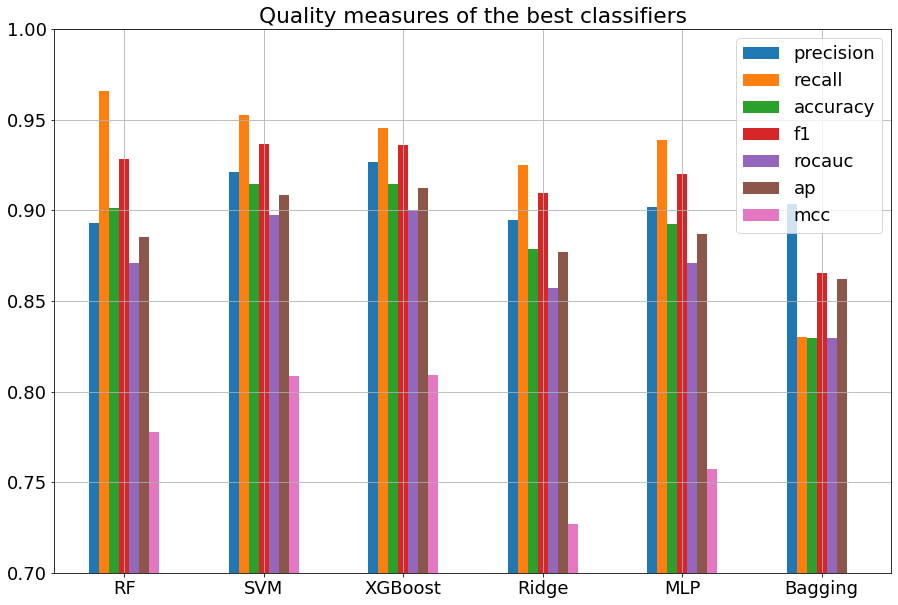

In [99]:
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(nrows=1, ncols=1)
ax1 = best_classifiers.plot.bar(ax=axes, title="Quality measures of the best classifiers", figsize=(15, 10))
labels = [item.split(",")[0] for item in  best_classifiers["use case"].to_list()]
ax1.set_xticklabels(labels, rotation=0)
plt.ylim(0.7, 1.0)
plt.grid()

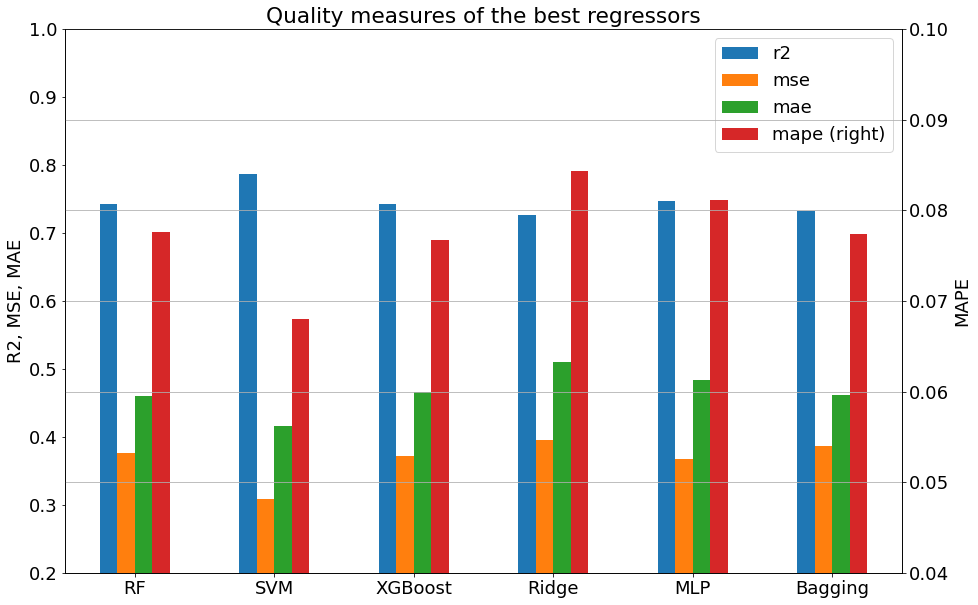

In [176]:
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(nrows=1, ncols=1)
best_regressors[["r2", "mse", "mae", "mape"]].plot.bar(position=0.5, ax=axes, 
                                               title="Quality measures of the best regressors", figsize=(15, 10), secondary_y="mape")
labels = [item.split(",")[0] for item in  best_classifiers["use case"].to_list()]
axes.set_xticklabels(labels, rotation=0)
ax1, ax2 = plt.gcf().get_axes()
ax1.set_ylim(0.2, 1.0)
ax2.set_ylim(0.04, 0.1)
ax1.set_ylabel("R2, MSE, MAE")
ax2.set_ylabel("MAPE")
plt.grid()

In [102]:
best_regressors

,use case,r2,mse,msle,mae,mape
6,"RF,FP,NoPCA,median100,test",0.7423,0.3767,0.0075,0.4605,0.0776
14,"SVM,FPMD,Scaling,PCA128,mean100,test",0.7865,0.3093,0.0060,0.4162,0.0680
8,"XGBoost,FP,NoPCA,mean100,test",0.7429,0.3724,0.0072,0.4663,0.0767
20,"Ridge,FPMD,Scaling,PCA256,mean100,test",0.7268,0.3958,0.0079,0.5096,0.0844
8,"MLP,FPMD,Scaling,PCA128,mean100,test",0.7467,0.3669,0.0074,0.4839,0.0811
8,"Bagging,FP,NoPCA,mean100,test",0.7328,0.3870,0.0076,0.4621,0.0774
